In [ ]:
# Imports and setup
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,
    accuracy_score
)
from sklearn.model_selection import KFold
from sklearn.base import clone

In [2]:
# Define cohort
cohort = "mimic_cohort_aplasia_45_days"

# Load data
print("Loading Data...")
try:
    # Load Target Labels
    target = pd.read_csv(f"../data/{cohort}/{cohort}.csv.gz", compression="gzip", index_col=0)
    # Load 'Up To' ICD Codes
    icd_codes_data = pd.read_csv(f"../data/{cohort}/{cohort}_icd_codes_upto.csv.gz", compression="gzip", index_col=0) 
    # Preprocessing: Create Groups
    icd_codes_data["icd_code_group"] = icd_codes_data["icd_code"].str[:3]
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Check paths.")

Loading Data...
Files loaded successfully.


In [3]:
# Feature Engineering (Full, Groups, Combined)
print("\n--- Generating Feature Matrices ---")

# Full Codes
print("Generating X_full (Full Codes)...")
X_full = icd_codes_data.groupby(["hadm_id", "icd_code"]).size().unstack("icd_code").fillna(0).astype(int)
X_full = (X_full > 0).astype(int)

# Code Groups
print("Generating X_groups (Code Groups)...")
X_groups = icd_codes_data.groupby(["hadm_id", "icd_code_group"]).size().unstack("icd_code_group").fillna(0).astype(int)
X_groups = (X_groups > 0).astype(int)

# Align Indices of Groups to Full
X_groups = X_groups.reindex(X_full.index, fill_value=0)

# Combined
print("Generating X_combined (Combined)...")
X_combined = pd.concat([X_full, X_groups], axis=1)

print(f"Dimensions -> Full: {X_full.shape}, Groups: {X_groups.shape}, Combined: {X_combined.shape}")

# DATA ALIGNMENT (Robustly aligns features and labels for the 'Up To' set)
target_indexed = target.set_index("hadm_id")
valid_ids = X_full.index.intersection(target_indexed.index)

print(f"\nAligning Data: Reduced from {len(X_full)} to {len(valid_ids)} valid admissions.")

# Filter all matrices to valid IDs
X_full = X_full.loc[valid_ids]
X_groups = X_groups.loc[valid_ids]
X_combined = X_combined.loc[valid_ids]
y_full = target_indexed.loc[valid_ids]["label"]

print(f"Valid (matching) hadm_ids: {len(valid_ids)}")
print("Label distribution:")
print(y_full.value_counts())


--- Generating Feature Matrices ---
Generating X_full (Full Codes)...
Generating X_groups (Code Groups)...
Generating X_combined (Combined)...
Dimensions -> Full: (10299, 6952), Groups: (10299, 1683), Combined: (10299, 8635)

Aligning Data: Reduced from 10299 to 4539 valid admissions.
Valid (matching) hadm_ids: 4539
Label distribution:
label
0    3529
1    1010
Name: count, dtype: int64


In [4]:
# Model Configuration 
models_config = {
    "XGBoost": XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=6, eval_metric="logloss", n_jobs=-1, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42),
    "CatBoost": CatBoostClassifier(
        iterations=200, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)
}

feature_datasets = {
    "Full Codes": X_full,
    "Groups": X_groups,
    "Combined": X_combined
}

In [5]:
# Training and Evaluation (Using dynamic KFold for the 'Up To' cohort)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indices = list(kf.split(valid_ids))

results_data = []

for feat_name, X_data in feature_datasets.items():
    print(f"\n--- Processing Features: {feat_name} ---")
    
    for model_name, base_model in models_config.items():
        print(f"  Training {model_name}...", end=" ")        
        fold_auc = []
        
        for train_idx, test_idx in fold_indices:
            X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
            y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]
            
            model = clone(base_model)
            
            if model_name in ["XGBoost", "CatBoost"]:
                ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
                model.set_params(scale_pos_weight=ratio)
            
            model.fit(X_train, y_train)
            y_prob = model.predict_proba(X_test)[:, 1]
            
            fold_auc.append(roc_auc_score(y_test, y_prob))
            
        avg_auc = np.mean(fold_auc)
        print(f"-> Avg AUC: {avg_auc:.4f}")
        
        results_data.append({
            "Model": model_name,
            "Features": feat_name,
            "AUC": avg_auc
        })


--- Processing Features: Full Codes ---
  Training XGBoost... -> Avg AUC: 0.8168
  Training RandomForest... -> Avg AUC: 0.8090
  Training CatBoost... -> Avg AUC: 0.8199

--- Processing Features: Groups ---
  Training XGBoost... -> Avg AUC: 0.8183
  Training RandomForest... -> Avg AUC: 0.7971
  Training CatBoost... -> Avg AUC: 0.8126

--- Processing Features: Combined ---
  Training XGBoost... -> Avg AUC: 0.8442
  Training RandomForest... -> Avg AUC: 0.8130
  Training CatBoost... -> Avg AUC: 0.8307


In [6]:
# Summary Table
summary_df = pd.DataFrame(results_data)
print("\nSummary Results:")
display(summary_df.pivot(index="Model", columns="Features", values="AUC"))


# Final Model Selection 
print("\n--- Selecting Best Model Configuration ---")

# Determine the winner based on the results calculated above
best_row = summary_df.loc[summary_df['AUC'].idxmax()]
best_model_name = best_row['Model']
best_features_name = best_row['Features']
best_auc = best_row['AUC']

print(f"WINNER: {best_model_name} using {best_features_name} (Avg AUC: {best_auc:.4f})")

# Select final data for the winner
if best_features_name == "Full Codes": X_final = X_full
elif best_features_name == "Groups": X_final = X_groups
else: X_final = X_combined

# The target vector is already aligned
y_final = y_full

# Instantiate Final deployable model (n_estimators/iterations set to 500)
if best_model_name == "XGBoost":
    final_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, eval_metric="logloss", n_jobs=-1, random_state=42)
elif best_model_name == "RandomForest":
    final_model = RandomForestClassifier(n_estimators=500, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42)
elif best_model_name == "CatBoost":
    final_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)

# Apply scale_pos_weight for boosting models
if best_model_name in ["XGBoost", "CatBoost"]:
    final_ratio = float(np.sum(y_final == 0)) / np.sum(y_final == 1)
    final_model.set_params(scale_pos_weight=final_ratio)
    
# Train the final model on ALL data (for deployment)
print(f"Training final {best_model_name} model on {len(X_final)} samples (for saving)...")
final_model.fit(X_final, y_final)


Summary Results:


Features,Combined,Full Codes,Groups
Model,,,
CatBoost,0.830718,0.819876,0.812636
RandomForest,0.813024,0.808987,0.797053
XGBoost,0.844172,0.816825,0.818334



--- Selecting Best Model Configuration ---
WINNER: XGBoost using Combined (Avg AUC: 0.8442)
Training final XGBoost model on 4539 samples (for saving)...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'



Aggregating CV Test Set Predictions
Aggregate AUC (on CV Test Folds): 0.8428


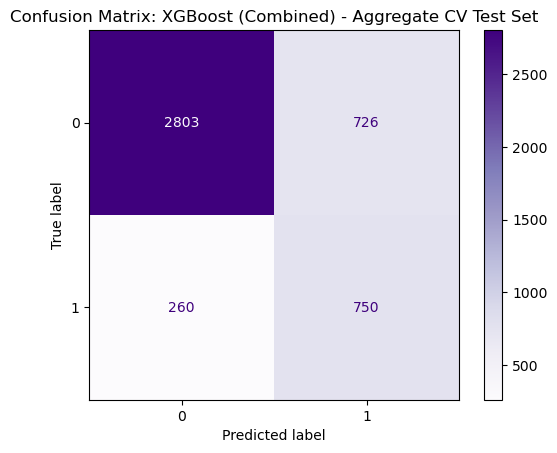

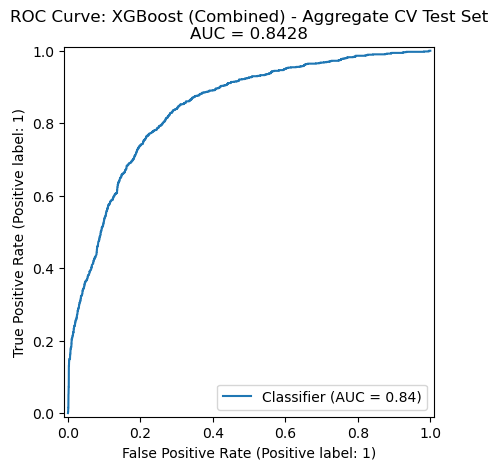

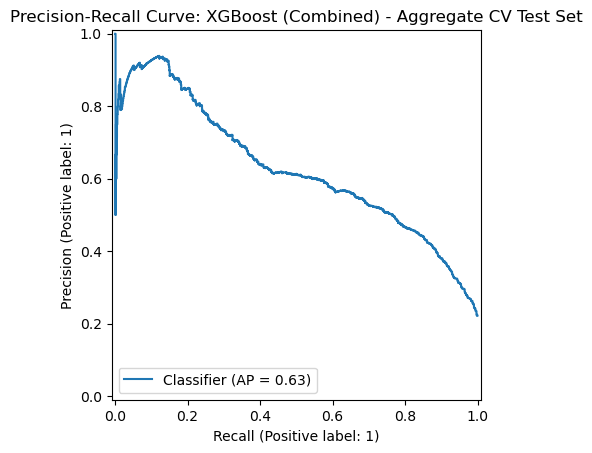


Final model saved successfully: ../models/mimic_cohort_aplasia_45_days_icd_codes_upto_XGBoost_Combined_model.pkl


In [7]:
# Re-run CV for the Winner to get AGGREGATE PLOTS (avoiding data leakage) 
print("\nAggregating CV Test Set Predictions")
X_data_for_cv = X_final 
y_data_for_cv = y_final

# Clone the base CV model parameters (N=200/iterations=200)
if best_model_name == "XGBoost":
    cv_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, eval_metric="logloss", n_jobs=-1, random_state=42)
elif best_model_name == "RandomForest":
    cv_model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42)
elif best_model_name == "CatBoost":
    cv_model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)

all_y_test_agg = []
all_y_pred_agg = []
all_y_prob_agg = []

# Re-run the K-Fold loop (using fold_indices created above)
for train_idx, test_idx in fold_indices: 
    X_train, X_test = X_data_for_cv.iloc[train_idx], X_data_for_cv.iloc[test_idx]
    y_train, y_test = y_data_for_cv.iloc[train_idx], y_data_for_cv.iloc[test_idx]
    
    model = clone(cv_model)
    
    if best_model_name in ["XGBoost", "CatBoost"]:
        ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
        model.set_params(scale_pos_weight=ratio)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    all_y_test_agg.extend(y_test)
    all_y_pred_agg.extend(y_pred)
    all_y_prob_agg.extend(y_prob)

all_y_test_agg = np.array(all_y_test_agg)
all_y_pred_agg = np.array(all_y_pred_agg)
all_y_prob_agg = np.array(all_y_prob_agg)

# Calculate the single aggregate AUC
agg_auc_final = roc_auc_score(all_y_test_agg, all_y_prob_agg)
print(f"Aggregate AUC (on CV Test Folds): {agg_auc_final:.4f}")

# Plotting with the aggregate data (non-overfit)
plot_title = f"{best_model_name} ({best_features_name}) - Aggregate CV Test Set"

# Confusion Matrix Plot
cm = confusion_matrix(all_y_test_agg, all_y_pred_agg)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Purples)
plt.title(f"Confusion Matrix: {plot_title}")
plt.show()
# ROC Curve Plot 
RocCurveDisplay.from_predictions(all_y_test_agg, all_y_prob_agg)
plt.title(f"ROC Curve: {plot_title}\nAUC = {agg_auc_final:.4f}")
plt.show()
# Precision-Recall Curve Plot 
PrecisionRecallDisplay.from_predictions(all_y_test_agg, all_y_prob_agg)
plt.title(f"Precision-Recall Curve: {plot_title}")
plt.show()

# Save the model using joblib

model_filename = f"../models/{cohort}_icd_codes_upto_{best_model_name}_{best_features_name.replace(' ', '_')}_model.pkl"
joblib.dump(final_model, model_filename)
print(f"\nFinal model saved successfully: {model_filename}")